In [219]:
# original script: https://zenodo.org/records/4090925
# Here I want to rewrite it with biotite and expand it to use for globular protein

from __future__ import annotations

from pathlib import Path
from typing import Optional, Tuple, Union, Dict, List

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import LineCollection

import biotite.structure as struc
import biotite.structure.io as strucio
import biotite.database.rcsb as rcsb
import biotite.structure.io.pdbx as pdbx
import biotite.structure.io.pdb as pdbio

from IPython.display import SVG, display


# ===== Bead SVG style (same setting as atom2svg) =====
RADIUS = 10 # radius of the circles representing residues (in pixels)
MARGIN = 5.0 # margin around the circles (in pixels)

# Schematic spacing (increase these if you have many labels)
DX = 3.0 # horizontal spacing between residues (in pixels)
DY = 10.0 # vertical spacing between rows (in pixels)
BRANCH = 3 # horizontal spacing for branches (in pixels)
STEM_W = 0.7 # width of the stem (in pixels)

# Backbone widths by SSE
LW_BETA  = 3 # width of the line representing beta strands (in pixels)
LW_HELIX = 3 # width of the line representing helices (in pixels)
LW_LOOP  = 0.2 # width of the line representing loops (in pixels)

# Labels
LABEL_EVERY = 7 # label every n-th residue (set to 1 to label all residues)
RESI_OFFSET_PTS = (0, 10) # offset of the residue number label from the circle center (in pixels)
FONT_AA = 10 # font size for the one-letter amino acid code (in points)
FONT_RESI = 6 # font size for the residue number (in points)

# Schematic wrapping
MAX_PER_ROW = 40 # maximum number of residues per row

# Overlap guarantee
MAX_INFLATE_ITERS = 12 # maximum number of iterations to inflate the circles to resolve overlaps
INFLATE_FACTOR = 1.18 # factor by which to inflate the circles in each iteration (e.g. 1.18 means increasing the radius by 18% in each iteration)


one_letter_code = {'ARG': 'R', 'HIS': 'H', 'LYS': 'K', 'ASP': 'D', 'GLU': 'E',
                   'SER': 'S', 'THR': 'T', 'ASN': 'N', 'GLN': 'Q', 'CYS': 'C',
                   'GLY': 'G', 'PRO': 'P', 'ALA': 'A', 'VAL': 'V', 'ILE': 'I',
                   'LEU': 'L', 'MET': 'M', 'PHE': 'F', 'TYR': 'Y', 'TRP': 'W'}

residue_class = {'ARG': 'b', 'HIS': 'b', 'LYS': 'b', 'ASP': 'a', 'GLU': 'a',
                 'SER': 'w', 'THR': 'w', 'ASN': 'w', 'GLN': 'w', 'CYS': 's',
                 'GLY': 'g', 'PRO': 'p', 'ALA': 'n', 'VAL': 'n', 'ILE': 'n',
                 'LEU': 'n', 'MET': 's', 'PHE': 'n', 'TYR': 'n', 'TRP': 'n'}

CLASS_TO_FILL = {
    "a": "red", "b": "skyblue", "w": "green", "g": "pink",
    "n": "white", "s": "yellow", "p": "purple",
}

def aa1(res3: str) -> str:
    return one_letter_code.get(res3.upper(), "X")

def aa_class(res3: str) -> str:
    return residue_class.get(res3.upper(), "n")



In [220]:
def load_structure_local(path: Union[str, Path], model: int = 1) -> struc.AtomArray:
    arr = strucio.load_structure(str(path))
    if isinstance(arr, struc.AtomArrayStack):
        idx = max(0, min(arr.stack_depth() - 1, model - 1))
        arr = arr[idx]
    return arr

def load_structure_rcsb_safe(pdb_id: str, model: int = 1):
    """
    Robust structure fetcher:
    - Try bcif (fast) but some entries crash in Biotite due to ins_code decoding
    - Fall back to cif
    - Fall back to pdb

    Returns:
      (atom_array, pdbx_file_or_none)

    If pdbx_file is not None, you can try pdbx.get_sse(pdbx_file).
    """
    pdb_id = pdb_id.upper()

    # 1) Try bcif
    try:
        bcif_path = rcsb.fetch(pdb_id, "bcif")
        bcif = pdbx.BinaryCIFFile.read(bcif_path)
        arr = pdbx.get_structure(bcif, model=model)
        # If it returns AtomArrayStack for some reason, pick first
        if hasattr(arr, "stack_depth"):
            arr = arr[0]
        return arr, bcif
    except Exception as e_bcif:
        print(f"[load_structure_rcsb_safe] bcif failed ({type(e_bcif).__name__}): {e_bcif}")

    # 2) Try cif
    try:
        cif_path = rcsb.fetch(pdb_id, "cif")
        cif = pdbx.CIFFile.read(cif_path)
        arr = pdbx.get_structure(cif, model=model)
        if hasattr(arr, "stack_depth"):
            arr = arr[0]
        return arr, cif
    except Exception as e_cif:
        print(f"[load_structure_rcsb_safe] cif failed ({type(e_cif).__name__}): {e_cif}")

    # 3) Try pdb
    pdb = pdbio.PDBFile.read(rcsb.fetch(pdb_id, "pdb"))
    arr = pdbio.get_structure(pdb, model=model)
    if hasattr(arr, "stack_depth"):
        arr = arr[0]
    return arr, None

def select_chain_amino_acids(arr: struc.AtomArray, chain_id: str) -> struc.AtomArray:
    return arr[struc.filter_amino_acids(arr) & (arr.chain_id == chain_id)]

def residue_table_from_ca(aa: struc.AtomArray) -> Tuple[np.ndarray, np.ndarray]:
    ca = aa[aa.atom_name == "CA"]
    if len(ca) == 0:
        raise ValueError("No CA atoms found.")
    order = np.argsort(ca.res_id.astype(int))
    ca = ca[order]
    return ca.res_id.astype(int), ca.res_name.astype(str)


In [221]:
def sse_to_coarse(s: str) -> str:
    """
    Convert various SSE codes into:
      'E' beta, 'H' helix, '-' loop
    """
    if s in ("E", "B", "b"):   # sheet-ish
        return "E"
    if s in ("H", "G", "I", "a"):  # helix-ish (PSEA uses 'a' sometimes)
        return "H"
    return "-"

def get_sse_biotite(arr: struc.AtomArray, chain_id: str, *, pdbx_file=None) -> np.ndarray:
    """
    SSE aligned to CA residues for chain_id.
    Priority:
      1) pdbx.get_sse(pdbx_file)[chain_id] if available AND length matches CA residues
      2) DSSP if available AND length matches
      3) struc.annotate_sse() fallback
    Output is coarse: 'E','H','-'
    """
    aa = select_chain_amino_acids(arr, chain_id)
    ca = aa[aa.atom_name == "CA"]
    order = np.argsort(ca.res_id.astype(int))
    ca = ca[order]
    res_ids = ca.res_id.astype(int)

    def sse_to_coarse(s: str) -> str:
        if s in ("E", "B", "b"):
            return "E"
        if s in ("H", "G", "I", "a"):
            return "H"
        return "-"

    # 1) From structure file annotations (works for many mmCIFs)
    if pdbx_file is not None:
        try:
            sse_map = pdbx.get_sse(pdbx_file)
            if chain_id in sse_map:
                raw = np.array(list(sse_map[chain_id]), dtype="<U1")
                if len(raw) == len(res_ids):
                    return np.array([sse_to_coarse(x) for x in raw], dtype="<U1")
        except Exception:
            pass

    # 2) DSSP
    try:
        from biotite.application.dssp import DsspApp
        app = DsspApp(aa)
        app.start(); app.join()
        raw = np.array(list(app.get_sse()), dtype="<U1")
        if len(raw) == len(res_ids):
            return np.array([sse_to_coarse(x) for x in raw], dtype="<U1")
    except Exception:
        pass

    # 3) Built-in P-SEA-like
    try:
        raw = np.array(list(struc.annotate_sse(aa)), dtype="<U1")
        if len(raw) == len(res_ids):
            return np.array([sse_to_coarse(x) for x in raw], dtype="<U1")
    except Exception:
        pass

    return np.array(["-"] * len(res_ids), dtype="<U1")



In [222]:
def build_feature_map_layout(res_ids: np.ndarray, res_names: np.ndarray, sse: np.ndarray):
    """
    Make a 2D schematic like a feature map:
      - residues laid out on rows with wrap
      - row direction snakes to reduce crossings
      - beads staggered above/below the rail
      - SSE affects line width later (not geometry)
    """
    n = len(res_ids)
    rail_xy = np.zeros((n,2), float)

    row = 0
    col = 0
    direction = 1  # 1 left->right, -1 right->left

    for i in range(n):
        if col >= MAX_PER_ROW:
            row += 1
            col = 0
            direction *= -1

        x = col * DX
        y = -row * DY
        if direction == -1:
            x = (MAX_PER_ROW - 1 - col) * DX
        rail_xy[i] = (x, y)
        col += 1

    rail_xy -= rail_xy.mean(axis=0, keepdims=True)

    # normals for staggering
    d = np.zeros_like(rail_xy)
    if n >= 2:
        d[1:-1] = rail_xy[2:] - rail_xy[:-2]
        d[0] = rail_xy[1] - rail_xy[0]
        d[-1] = rail_xy[-1] - rail_xy[-2]
    dn = np.linalg.norm(d, axis=1, keepdims=True)
    dn[dn == 0] = 1.0
    t = d / dn
    normal = np.stack([-t[:,1], t[:,0]], axis=1)

    side = np.where((np.arange(n) % 2) == 0, 1.0, -1.0)
    gly = np.array([rn.upper() == "GLY" for rn in res_names], dtype=bool)
    branch = np.where(gly, BRANCH*0.6, BRANCH)

    bead_xy = rail_xy + (side[:,None] * branch[:,None]) * normal
    seg_tag = sse[:-1]  # per segment i->i+1
    return rail_xy, bead_xy, seg_tag


In [223]:
from matplotlib.patches import Circle

def plot_for_overlap(ax, rail_xy, bead_xy, res_ids, res_names, seg_tag):
    """
    Matplotlib preview used for overlap detection.
    - beta (E): thick solid
    - helix (H): dashed
    - loop (-): thin solid
    """
    # --- Backbone segments with SSE-dependent linewidth + linestyle ---
    for i in range(len(rail_xy) - 1):
        x1, y1 = rail_xy[i]
        x2, y2 = rail_xy[i + 1]
        t = seg_tag[i]

        if t == "E":
            lw = LW_BETA
            ls = "solid"
        elif t == "H":
            lw = LW_HELIX
            ls = (0, (4, 3))   # dashed pattern: 4 on, 3 off
        else:
            lw = LW_LOOP
            ls = "solid"

        ax.plot([x1, x2], [y1, y2],
                color="black",
                linewidth=lw,
                linestyle=ls,
                solid_capstyle="round",
                solid_joinstyle="miter",
                zorder=1)

    # --- Stems + beads + labels ---
    for i, ((rx, ry), (bx, by), rid, rn) in enumerate(zip(rail_xy, bead_xy, res_ids, res_names)):
        # stem
        # Vector from rail to bead
        vx = bx - rx
        vy = by - ry
        norm = (vx**2 + vy**2)**0.5 + 1e-12

        # Stop stem at circle edge
        bx_edge = bx - RADIUS * vx / norm
        by_edge = by - RADIUS * vy / norm

        ax.plot([rx, bx_edge], [ry, by_edge],
                color="black",
                linewidth=STEM_W,
                zorder=2)

        # bead
        cls = aa_class(rn)
        fill = CLASS_TO_FILL.get(cls, "white")
        ax.add_patch(
            Circle((bx, by), radius=RADIUS,
                   facecolor=fill, edgecolor="black", linewidth=0.8, zorder=3)
        )

        # resn inside bead (one-letter)
        ax.text(bx, by, aa1(rn),
                ha="center", va="center",
                fontsize=FONT_AA, fontweight="bold",
                zorder=4, color="black")

        # Place resi along the stem direction (rail -> bead), outside the bead
        vx = bx - rx
        vy = by - ry
        norm = (vx*vx + vy*vy)**0.5 + 1e-12
        ux, uy = vx / norm, vy / norm

        gap = 0.8  # data units; tweak (0.6–1.4)
        tx = bx + (RADIUS + gap) * ux
        ty = by + (RADIUS + gap) * uy

        ax.text(tx, ty, str(int(rid)),
                ha="center", va="center",
                fontsize=FONT_RESI,
                zorder=4, color="black")

    ax.set_aspect("equal", adjustable="datalim")
    ax.axis("off")



def collect_bboxes(fig, ax):
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()
    bboxes = []

    for txt in ax.texts:
        bboxes.append(txt.get_window_extent(renderer=renderer))
    for p in ax.patches:
        bboxes.append(p.get_window_extent(renderer=renderer))
    for c in ax.collections:
        try:
            bboxes.append(c.get_window_extent(renderer=renderer))
        except Exception:
            pass
    for ln in ax.lines:
        try:
            bboxes.append(ln.get_window_extent(renderer=renderer))
        except Exception:
            pass
    return bboxes


def any_bbox_overlap(bboxes, eps_px: float = 0.5) -> bool:
    for i in range(len(bboxes)):
        a = bboxes[i].expanded(1.0 + eps_px/1000, 1.0 + eps_px/1000)
        for j in range(i+1, len(bboxes)):
            b = bboxes[j].expanded(1.0 + eps_px/1000, 1.0 + eps_px/1000)
            if a.overlaps(b):
                return True
    return False


def inflate_until_clean(rail_xy, bead_xy, res_ids, res_names, seg_tag):
    scale = 1.0
    for _ in range(MAX_INFLATE_ITERS):
        fig, ax = plt.subplots(figsize=(10, 7), dpi=150)
        plot_for_overlap(ax, rail_xy*scale, bead_xy*scale, res_ids, res_names, seg_tag)
        fig.tight_layout(pad=0.1)
        bboxes = collect_bboxes(fig, ax)
        overlap = any_bbox_overlap(bboxes)
        plt.close(fig)
        if not overlap:
            return scale
        scale *= INFLATE_FACTOR
    return scale


In [ ]:
def schematic_to_svg(rail_xy, bead_xy, res_ids, res_names, seg_tag, scale10=10.0):
    all_xy = np.vstack([rail_xy, bead_xy])
    minx = float(all_xy[:,0].min()) - MARGIN
    miny = float(all_xy[:,1].min()) - MARGIN
    maxx = float(all_xy[:,0].max()) + MARGIN
    maxy = float(all_xy[:,1].max()) + MARGIN

    W = int(scale10*(maxx-minx))
    H = int(scale10*(maxy-miny))

    svg = []
    svg.append(f'''<?xml version="1.0" standalone="no"?>
<svg viewBox="0 0 {W} {H}" version="1.1" xmlns="http://www.w3.org/2000/svg">
<style>
 line {{stroke: black; stroke-width: 0.2px;}}
 .beta  {{stroke-width: 0.55px;}}
 .helix {{stroke-width: 0.42px; stroke-dasharray: 4 3;}}
 .loop  {{stroke-width: 0.22px;}}
 .sidechain {{stroke-width: 0.2px;}}

 circle {{stroke: black; stroke-width: 0.2px;}}
 .a {{fill: red;}}
 .b {{fill: skyblue;}}
 .w {{fill: green;}}
 .g {{fill: pink;}}
 .n {{fill: white;}}
 .s {{fill: yellow;}}
 .p {{fill: purple;}}
 .aa {{font-family: sans-serif; font-size: 1.76px; text-anchor: middle;}}
 .resi {{font-family: sans-serif; font-size: 1.50px; text-anchor: middle;}}
</style>
<g transform="scale({scale10}) translate({-minx:.6f}, {-miny:.6f})">
''')

    # Backbone
    for i in range(len(rail_xy)-1):
        x1,y1 = rail_xy[i]
        x2,y2 = rail_xy[i+1]
        t = seg_tag[i]
        cls = "loop"
        if t == "E": cls = "beta"
        elif t == "H": cls = "helix"
        vx = bx - rx
        vy = by - ry
        norm = (vx*vx + vy*vy)**0.5 + 1e-12
        bx_edge = bx - RADIUS * vx / norm
        by_edge = by - (RADIUS * vy) / norm

        svg.append(
            f' <line x1="{rx:.6f}" y1="{ry:.6f}" '
            f'x2="{bx_edge:.6f}" y2="{by_edge:.6f}" '
            f'class="sidechain" />\n'
        )

    # Beads and stems
    for i, ((rx,ry),(bx,by),rid,rn) in enumerate(zip(rail_xy, bead_xy, res_ids, res_names)):
        cls = aa_class(rn)
        svg.append(f' <line x1="{rx:.6f}" y1="{ry:.6f}" x2="{bx:.6f}" y2="{by:.6f}" class="sidechain" />\n')
        svg.append(f' <circle cx="{bx:.6f}" cy="{by:.6f}" r="{RADIUS:.6f}" class="{cls}" />\n')
        svg.append(f' <text x="{bx:.6f}" y="{(by + RADIUS/2.0):.6f}" class="aa">{aa1(rn)}</text>\n')
        if (i % LABEL_EVERY) == 0:
            svg.append(f' <text x="{bx:.6f}" y="{(by + RADIUS + 1.2):.6f}" class="resi">{int(rid)}</text>\n')
        svg.append("\n")

    svg.append("</g>\n</svg>\n")
    return "".join(svg)


In [225]:
def schematic_to_svg(
    rail_xy: np.ndarray,
    bead_xy: np.ndarray,
    res_ids: np.ndarray,
    res_names: np.ndarray,
    seg_tag: np.ndarray,
    *,
    scale10: float = 10.0,
    margin: float = MARGIN,
) -> str:
    """
    Convert schematic coords into an SVG in your atom2svg style.
    (We use the same classes a/b/w/n/g/s/p.)
    """
    # Compute bounds from rail+beads
    all_xy = np.vstack([rail_xy, bead_xy])
    minx = float(all_xy[:,0].min()) - margin
    miny = float(all_xy[:,1].min()) - margin
    maxx = float(all_xy[:,0].max()) + margin
    maxy = float(all_xy[:,1].max()) + margin

    W = int(scale10 * (maxx - minx))
    H = int(scale10 * (maxy - miny))

    # SVG header + styles
    svg = []
    svg.append(f'''<?xml version="1.0" standalone="no"?>
<svg viewBox="0 0 {W} {H}" version="1.1" xmlns="http://www.w3.org/2000/svg">
<style>
 line {{stroke: black; stroke-width: 0.2px;}}
 .mainchain {{stroke-width: 0.4px;}}
 .sidechain {{stroke-width: 0.2px;}}

 /* We'll emulate SSE widths by duplicating strokes with thicker widths */
 .beta {{stroke-width: 0.55px;}}
 .helix {{stroke-width: 0.42px;}}
 .loop {{stroke-width: 0.22px;}}

 circle {{stroke: black; stroke-width: 0.2px;}}
 .a {{fill: red;}}
 .b {{fill: skyblue;}}
 .w {{fill: green;}}
 .g {{fill: pink;}}
 .n {{fill: white;}}
 .s {{fill: yellow;}}
 .p {{fill: purple;}}
 .aa {{font-family: sans-serif; font-size: 1.76px; text-anchor: middle;}}
 .resi {{font-family: sans-serif; font-size: 1.50px; text-anchor: middle;}}
</style>
<g transform="scale({scale10}) translate({-minx:.6f}, {-miny:.6f})">
''')

    # Backbone rail segments with SSE classes
    for i in range(len(rail_xy) - 1):
        x1, y1 = rail_xy[i]
        x2, y2 = rail_xy[i+1]
        t = seg_tag[i]
        cls = "loop"
        if t == "E":
            cls = "beta"
        elif t == "H":
            cls = "helix"
        svg.append(f' <line x1="{x1:.6f}" y1="{y1:.6f}" x2="{x2:.6f}" y2="{y2:.6f}" class="{cls}" />\n')

    # Stems + beads + labels
    for i, ((rx, ry), (bx, by), rid, rn) in enumerate(zip(rail_xy, bead_xy, res_ids, res_names)):
        res3 = rn.upper()
        cls = aa_class(res3)
        # stem
        svg.append(f' <line x1="{rx:.6f}" y1="{ry:.6f}" x2="{bx:.6f}" y2="{by:.6f}" class="sidechain" />\n')
        # bead
        svg.append(f' <circle cx="{bx:.6f}" cy="{by:.6f}" r="{RADIUS:.6f}" class="{cls}" />\n')
        # aa1 inside
        svg.append(f' <text x="{bx:.6f}" y="{(by + RADIUS/2.0):.6f}" class="aa">{aa1(res3)}</text>\n')

        # residue id: in pure SVG, consistent "points" is annoying; we mimic by a small y offset in data units
        if (i % LABEL_EVERY) == 0:
            svg.append(f' <text x="{bx:.6f}" y="{(by + RADIUS + 1.2):.6f}" class="resi">{int(rid)}</text>\n')

        svg.append("\n")

    svg.append("</g>\n</svg>\n")
    return "".join(svg)


In [226]:
# input_path = "input.pdb"   # or .cif/.bcif
# chain_id = "A"
# model = 1

# arr = load_structure_local_safe(input_path, model=model)
# aa = select_chain_amino_acids(arr, chain_id)
# res_ids, res_names = residue_table_from_ca(aa)

# sse = get_sse_biotite(arr, chain_id, pdbx_file=None)  # local file: no pdbx annotations unless you load CIF separately

# rail_xy, bead_xy, seg_tag = build_feature_map_layout(res_ids, res_names, sse)

# scale = inflate_until_clean(rail_xy, bead_xy, res_ids, res_names, seg_tag)
# print("Final scale:", scale)

# rail2 = rail_xy * scale
# bead2 = bead_xy * scale

# # preview
# fig, ax = plt.subplots(figsize=(12,8), dpi=150)
# plot_for_overlap(ax, rail2, bead2, res_ids, res_names, seg_tag)
# plt.show()

# svg_text = schematic_to_svg(rail2, bead2, res_ids, res_names, seg_tag)
# display(SVG(svg_text))

# Path("globular_featuremap.svg").write_text(svg_text, encoding="utf-8")
# print("Saved globular_featuremap.svg")


[load_structure_rcsb_safe] bcif failed (DeserializationError): Failed to deserialize element 'pdbx_PDB_ins_code'
Final scale: 7.287592625109122


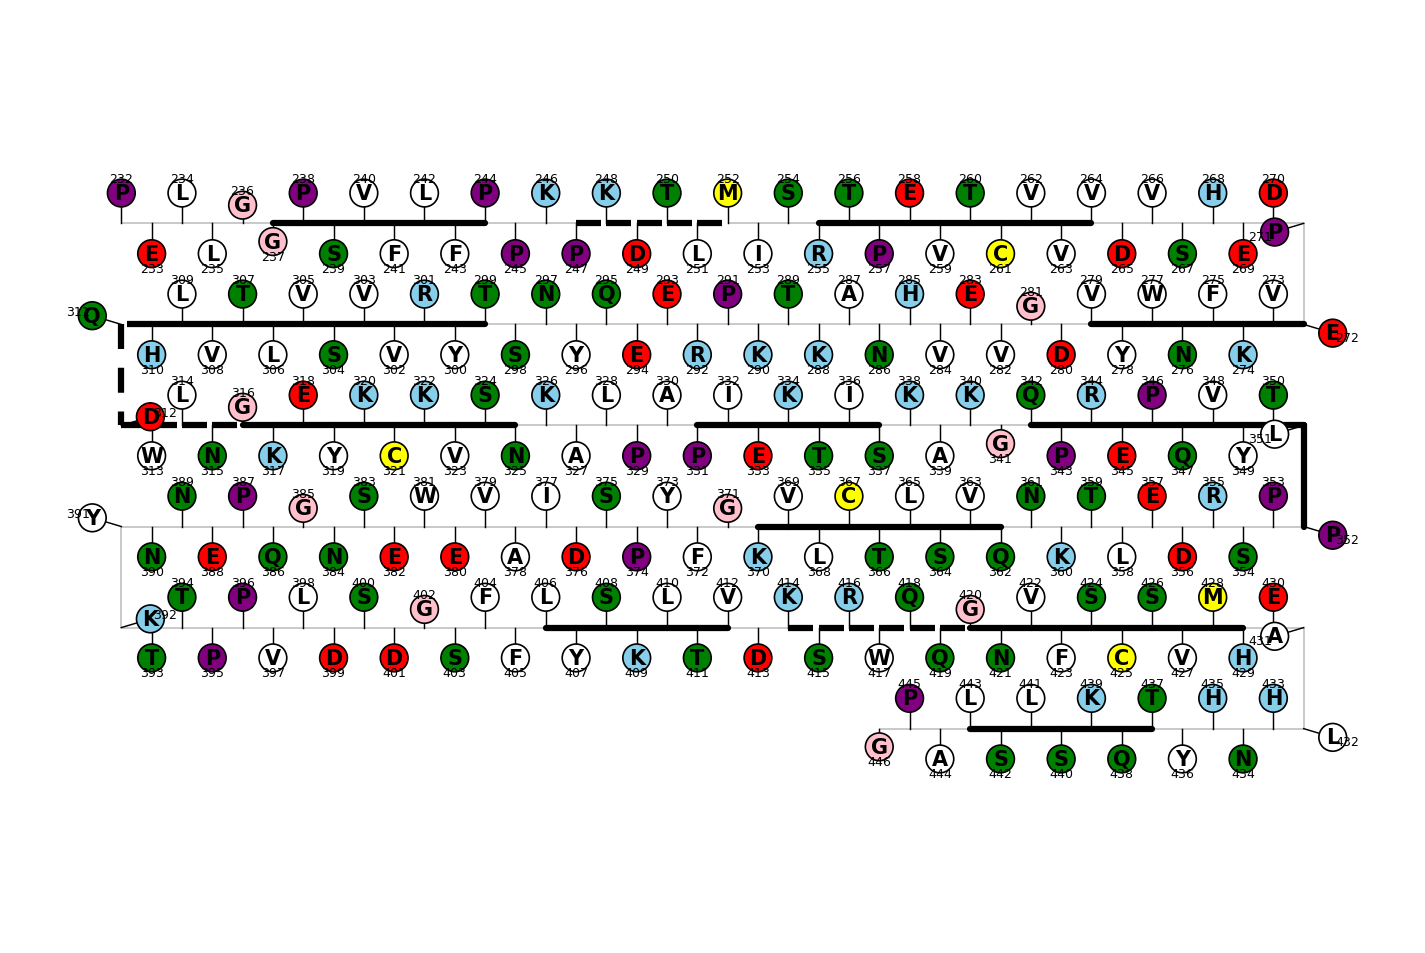

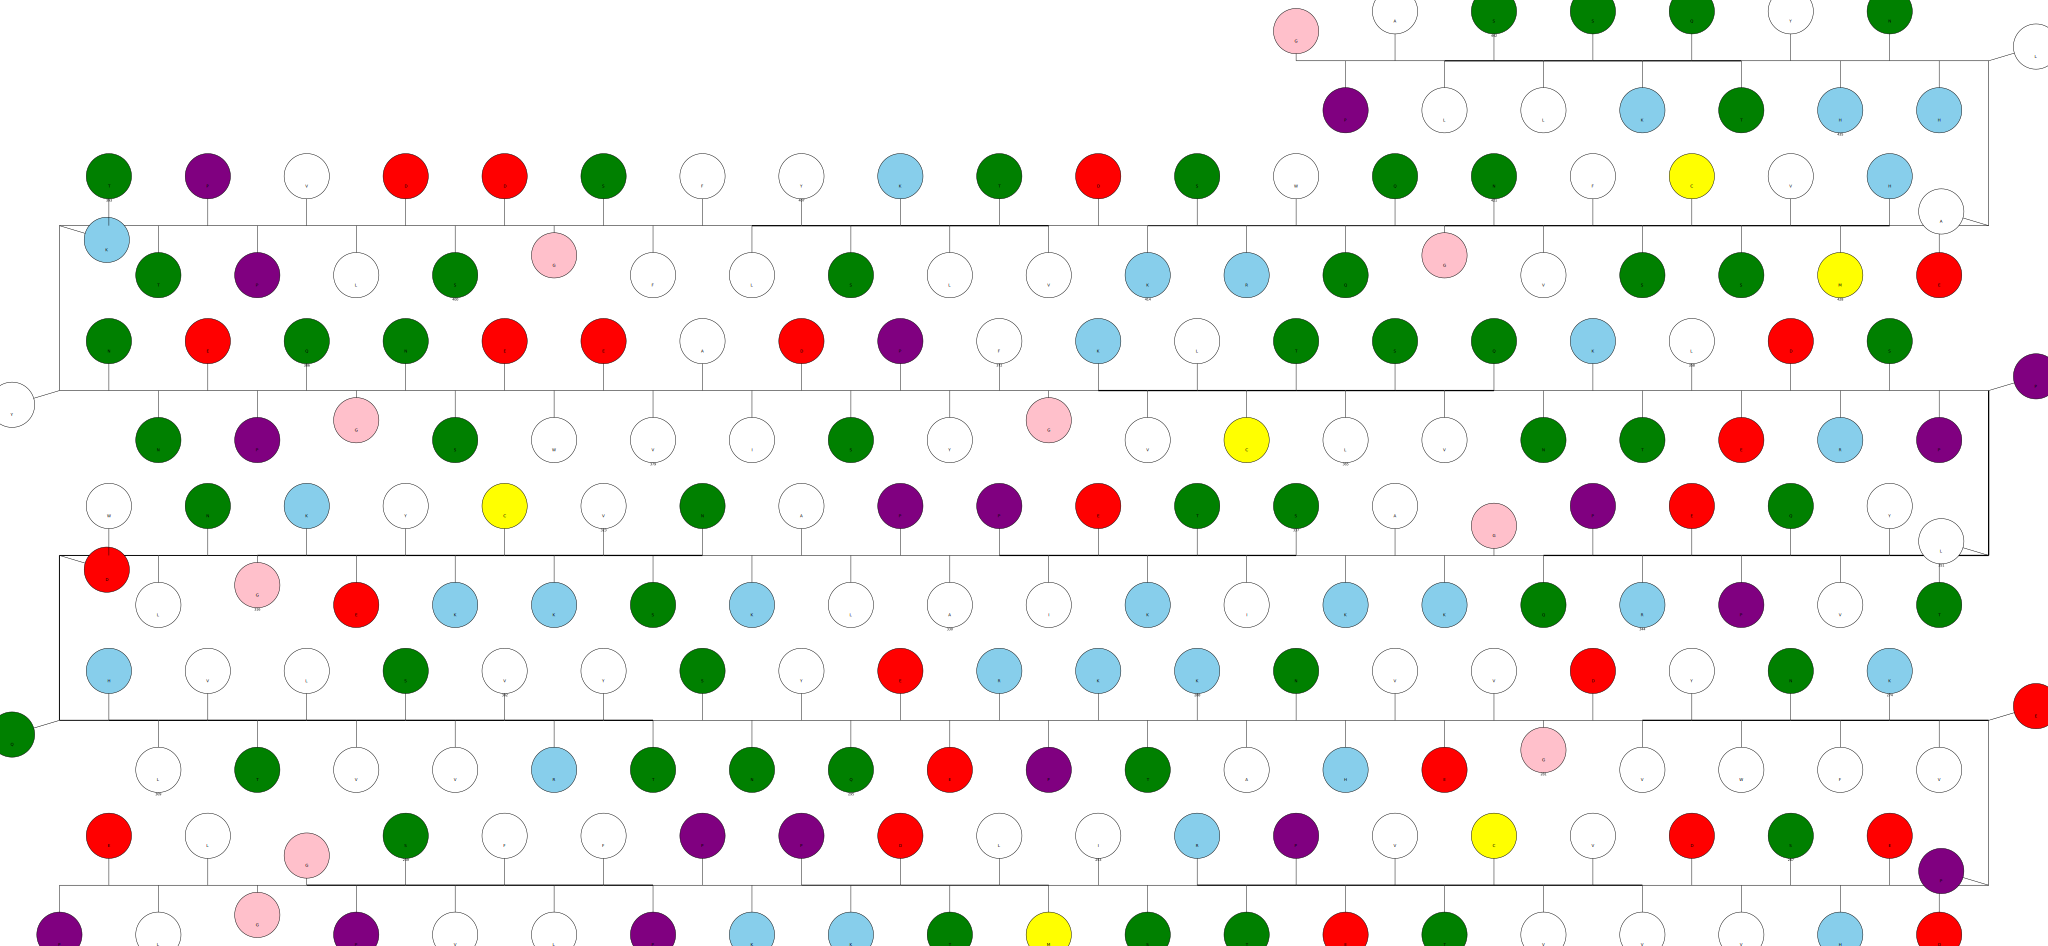

Saved 4W4O_A_featuremap.svg


In [227]:
pdb_id = "4W4O"
chain_id = "A"
model = 1

arr, pdbx_file = load_structure_rcsb_safe(pdb_id, model=model)
aa = select_chain_amino_acids(arr, chain_id)
res_ids, res_names = residue_table_from_ca(aa)

sse = get_sse_biotite(arr, chain_id, pdbx_file=pdbx_file)

rail_xy, bead_xy, seg_tag = build_feature_map_layout(res_ids, res_names, sse)

scale = inflate_until_clean(rail_xy, bead_xy, res_ids, res_names, seg_tag)
print("Final scale:", scale)

rail2 = rail_xy * scale
bead2 = bead_xy * scale

fig, ax = plt.subplots(figsize=(12,8), dpi=150)
plot_for_overlap(ax, rail2, bead2, res_ids, res_names, seg_tag)
plt.show()

svg_text = schematic_to_svg(rail2, bead2, res_ids, res_names, seg_tag)
display(SVG(svg_text))

out = f"{pdb_id}_{chain_id}_featuremap.svg"
Path(out).write_text(svg_text, encoding="utf-8")
print("Saved", out)
